In [1]:
!pip install qutip qutip-qip qutip-qtrl matplotlib

**Our team implemented a pulse-level crosstalk attack simulation against the B92 quantum key distribution protocol. We built a three-qubit model (two adjacent attacker qubits and one victim), encoded Alice’s signals as |0⟩ and |+⟩, and constructed a time-dependent Hamiltonian including Y⊗X and Z⊗X coupling. We injected configurable pulses (Gaussian, cosine, square, chirp, DRAG), evolved the system with QuTiP, and simulated Bob’s measurements. By sweeping pulse amplitude, detuning, and shapes we measured sifted key length and QBER, demonstrating parameter regimes that bias B92 outputs. Our work validates the attack concept and suggests mitigations such as scheduling isolation, canary checks, and telemetry.**

# Why X-type pulses increase QBER in the Z basis (short)
**Short answer:** Because the attack injects X-type rotations onto Alice’s qubit, it mostly corrupts Z-basis states (|0⟩/|1⟩) while leaving X-basis eigenstates (|+⟩/|−⟩) largely unchanged — so extra errors (QBER) appear primarily when Alice prepared in Z and Bob measured in Z.

**Why, simply:**
- An X-rotation leaves |+⟩,|−⟩ (X eigenstates) unchanged in measurement probabilities in the X basis.
- But it rotates |0⟩,|1⟩ (Z eigenstates) into superpositions, so Z measurements sometimes flip outcome → ↑QBER for Z.


IBMQ device

In [2]:
pip install qiskit-ibm-runtime

Note: you may need to restart the kernel to use updated packages.


In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import transpile


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="3A_tm6nOUA3I4eG06wHh6QMYPDSDb_06xZKNh6925n2c",
    overwrite=True
)

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Replace with your actual API key (or read from JSON if you prefer)
token = "3A_tm6nOUA3I4eG06wHh6QMYPDSDb_06xZKNh6925n2c"

QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token=token,
    overwrite=True
)

In [9]:
service = QiskitRuntimeService(channel="ibm_quantum")

RequestsApiError: 'HTTPSConnectionPool(host=\'auth.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/version (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001F91168B310>: Failed to resolve \'auth.quantum-computing.ibm.com\' ([Errno 11001] getaddrinfo failed)"))'

In [8]:
backends = service.backends()
for backend in backends:
    print(f"{backend.name:<15} | {backend.num_qubits:>2} qubits | {backend.backend_type()} | operational={backend.operational}")

NameError: name 'service' is not defined

In [7]:
real_devices = service.backends(simulator=False, operational=True)
print("Available superconducting qubit devices:\n")
for backend in real_devices:
    print(f"{backend.name:<15} | Qubits: {backend.num_qubits:<3} | Status: {'OK' if backend.operational else 'Down'} | Queue: {backend.status().pending_jobs}")

NameError: name 'service' is not defined

**Pulse Level attack on B92 protocol**

/usr/local/lib/python3.12/dist-packages/qutip/solver/solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


N=100, Pulse=Gaussian, Sifted=41, QBER=0.4390
N=250, Pulse=Gaussian, Sifted=94, QBER=0.3511
N=500, Pulse=Gaussian, Sifted=190, QBER=0.2737
N=700, Pulse=Gaussian, Sifted=265, QBER=0.2830


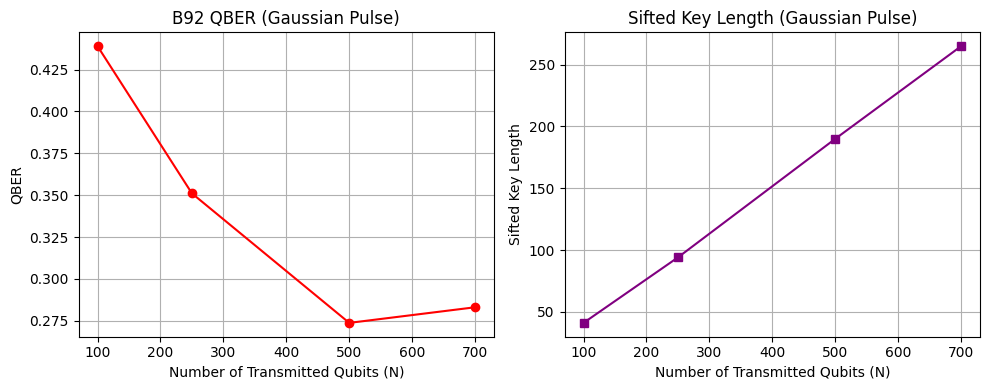

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from qutip import basis, tensor, sigmax, sigmay, sigmaz, qeye, mesolve

# -----------------------------
# Pauli operators
X = sigmax(); Y = sigmay(); Z = sigmaz(); I = qeye(2)

# -----------------------------
# Pulse shapes (from your image)
def pulse_cosine(t, A=1.0, delta=0.0, **kwargs):
    return A * np.cos(delta * t)

def pulse_gaussian(t, A=1.0, sigma=0.08, **kwargs):
    return A * np.exp(-((t - 0.5)**2) / (2 * sigma**2))

def pulse_square(t, A=1.0, **kwargs):
    return A if 0.3 < t <= 0.7 else 0.0

def pulse_chirp(t, A=1.0, delta=0.0, c=5.0, **kwargs):
    return A * np.cos((delta + c*t) * t)

def pulse_drag(t, A=1.0, sigma=0.08, alpha=2.0, **kwargs):
    return A * np.exp(-((t - 0.5)**2) / (2 * sigma**2)) - alpha * ((t - 0.5)**2) / (sigma**2)

pulse_shapes = {
    "Cosine": pulse_cosine,
    "Gaussian": pulse_gaussian,
    "Square": pulse_square,
    "Chirp": pulse_chirp,
    "DRAG": pulse_drag
}

# -----------------------------
# Simulation parameters
n_steps = 50
tlist = np.linspace(0, 1, n_steps)
sigma = 0.08

# Coupling and drive strengths
J01 = 1.0
J12 = 1.0
A0 = 1.0
A1 = 1.0

# -----------------------------
# Select pulse shape
chosen_shape = "Gaussian"   # Change this to: "Cosine", "Square", "Chirp", or "DRAG"
pulse_func = pulse_shapes[chosen_shape]

# Define Hamiltonian terms (3-qubit system: q0=Eve1, q1=Eve2, q2=Alice)
"""Evolve Alice’s B92 state under Eve’s pulse-level crosstalk attack. Here pulse injection happens"""
H_coup_01 = tensor(Y, X, I)
H_coup_12 = tensor(I, Z, X)
  # ✅ Drives (time-dependent) — This is where Eve injects her pulses
H_drive_0 = [tensor(X, I, I), lambda t, args: A0 * pulse_func(t)]
H_drive_1 = [tensor(I, X, I), lambda t, args: A1 * pulse_func(t)]
    # Full Hamiltonian (includes coupling + injected drives)

H = [J01 * H_coup_01 + J12 * H_coup_12, H_drive_0, H_drive_1]

# -----------------------------
# B92 states (Alice)
state_0 = basis(2, 0)  # |0>
state_plus = (basis(2, 0) + basis(2, 1)).unit()  # |+>

# Projectors for measurement
P0 = state_0 * state_0.dag()
P_plus = state_plus * state_plus.dag()

# -----------------------------
def evolve_three_qubit(state_q2):
    """Evolve 3-qubit system and return reduced density matrix of Alice's qubit q2."""

        # System starts as |0,0,ψ_Alice⟩  → Alice’s qubit is the third one

    psi0 = tensor(basis(2,0), basis(2,0), state_q2)
    result = mesolve(H, psi0, tlist, [], [])
    final = result.states[-1]
    return final.ptrace(2)

def measure_b92(rho, basis_choice):
    """Bob measures in Z or X basis."""
    if basis_choice == 0:
        p0 = np.real((P0 * rho).tr())
        return 0 if random.random() < p0 else 1
    else:
        p_plus = np.real((P_plus * rho).tr())
        return 0 if random.random() < p_plus else 1

def run_b92(N=200, seed=42):
    """Run B92 under Eve's crosstalk attack with configurable pulse shape."""
    random.seed(seed)
    alice_bits, bob_results, bob_bases = [], [], []

    for _ in range(N):
        bit = random.randint(0, 1)
        state = state_0 if bit == 0 else state_plus
        alice_bits.append(bit)
        rho_q2 = evolve_three_qubit(state)

        bob_basis = random.randint(0, 1)
        bob_bases.append(bob_basis)
        bob_results.append(measure_b92(rho_q2, bob_basis))

    # Sifting logic
    sift_alice, sift_bob = [], []
    for i in range(N):
        if bob_results[i] == 1:
            sift_alice.append(alice_bits[i])
            sift_bob.append(0 if bob_bases[i] == 1 else 1)

    mismatches = sum(a != b for a, b in zip(sift_alice, sift_bob))
    qber = mismatches / len(sift_alice) if sift_alice else 0.0
    return qber, len(sift_alice)

# -----------------------------
# Run simulation
N_values = [100, 250, 500, 700]
qbers, sift_lengths = [], []

for N in N_values:
    qber, sift_len = run_b92(N=N, seed=42)
    qbers.append(qber)
    sift_lengths.append(sift_len)
    print(f"N={N}, Pulse={chosen_shape}, Sifted={sift_len}, QBER={qber:.4f}")

# -----------------------------
# Plot results
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(N_values, qbers, 'o-', color='r')
plt.title(f"B92 QBER ({chosen_shape} Pulse)")
plt.xlabel("Number of Transmitted Qubits (N)")
plt.ylabel("QBER")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(N_values, sift_lengths, 's-', color='purple')
plt.title(f"Sifted Key Length ({chosen_shape} Pulse)")
plt.xlabel("Number of Transmitted Qubits (N)")
plt.ylabel("Sifted Key Length")
plt.grid(True)

plt.tight_layout()
plt.show()


# 🔒 B92 Pulse-Level Crosstalk Simulation — Simple Explanation

### What we built
We simulated how a malicious neighbour (Eve) can disturb **B92 Quantum Key Distribution**
by sending microwave pulses that leak through hardware couplings.

### How it works
- Alice encodes qubits as **|0⟩** and **|+⟩** (the two B92 states).  
- Eve controls two adjacent qubits and injects **X-type pulses** (Gaussian, Cosine, Square, Chirp, or DRAG).  
- These pulses interact through fixed couplings (**Y⊗X** and **Z⊗X**) and rotate Alice’s qubit.  
- Bob measures randomly in **Z** or **X** basis.

### What we measured
We evolved the 3-qubit system with **QuTiP**, then calculated the
**Quantum Bit Error Rate (QBER)** for:
1. Different **pulse amplitudes (A)**
2. Different **frequency detunings (δ)**
3. Different **pulse shapes**

### Why QBER rises
Because the injected pulse acts like an **X-rotation**, it mainly disturbs
Alice’s **Z-basis states (|0⟩)** — turning them partly into |1⟩.
So, **Z-basis measurements** show higher QBER, while **X-basis** stays stable.

### What the plots show
- **Left:** QBER ↑ as pulse amplitude grows (stronger disturbance).  
- **Middle:** QBER oscillates with detuning δ (frequency mismatch).  
- **Right:** Each pulse shape has a different attack strength.


**B92 pulse parameter model (same pulse shape functions, plots, and parameter sweeps) —**

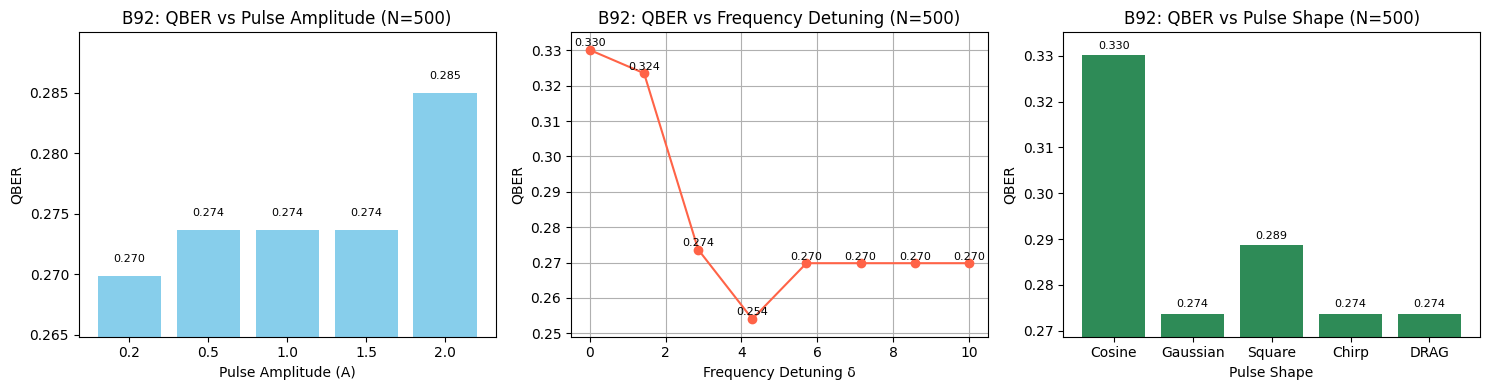

In [5]:
# Save as b92_pulse_params.py and run: python b92_pulse_params.py
import numpy as np
import random
import matplotlib.pyplot as plt
from qutip import basis, tensor, sigmax, sigmay, sigmaz, qeye, mesolve

# -----------------------------
# Pauli operators
X = sigmax(); Y = sigmay(); Z = sigmaz(); I = qeye(2)

# Time evolution setup
n_steps = 50
tlist = np.linspace(0, 1, n_steps)

# Crosstalk couplings
J01, J12 = 1.0, 1.0

# -----------------------------
# B92 states on Alice’s qubit (q2)
state_0 = basis(2,0)  # |0>
state_plus = (basis(2,0) + basis(2,1)).unit()  # |+>

# Projectors for measurement
P0 = state_0 * state_0.dag()
Pplus = state_plus * state_plus.dag()

# -----------------------------
# Pulse shapes
def pulse_cosine(t, A=1.0, delta=0.0, **kwargs):
    return A * np.cos(delta * t)

def pulse_gaussian(t, A=1.0, sigma=0.08, **kwargs):
    return A * np.exp(-((t-0.5)**2) / (2*sigma**2))

def pulse_square(t, A=1.0, **kwargs):
    return A if 0.3 <= t <= 0.7 else 0.0

def pulse_chirp(t, A=1.0, delta=0.0, c=5.0, **kwargs):
    return A * np.cos((delta + c*t) * t)

def pulse_drag(t, A=1.0, sigma=0.08, alpha=2.0, **kwargs):
    return A * np.exp(-((t-0.5)**2) / (2*sigma**2) - alpha*((t-0.5)**2)/(sigma**2))

pulse_shapes = {
    "Cosine": pulse_cosine,
    "Gaussian": pulse_gaussian,
    "Square": pulse_square,
    "Chirp": pulse_chirp,
    "DRAG": pulse_drag
}

# -----------------------------
def evolve_three_qubit(state_q2, pulse_func, A=1.0, delta=0.0):
    """Evolve Alice’s B92 state under Eve’s pulse-level crosstalk attack."""
    # Couplings: Y⊗X on q0,q1 and Z⊗X on q1,q2
    H_coup_01 = tensor(Y, X, I)
    H_coup_12 = tensor(I, Z, X)

    # Drives (time-dependent)
    H_drive_0 = [tensor(X, I, I), lambda t, args: pulse_func(t, A=A, delta=delta)]
    H_drive_1 = [tensor(I, X, I), lambda t, args: pulse_func(t, A=A, delta=delta)]

    H = [J01*H_coup_01 + J12*H_coup_12, H_drive_0, H_drive_1]

    psi0 = tensor(basis(2,0), basis(2,0), state_q2)
    result = mesolve(H, psi0, tlist, [], [])
    return result.states[-1].ptrace(2)

def measure_b92(rho, basis_choice):
    """Bob's measurement in Z (for |0⟩ detection) or X (for |+⟩ detection)."""
    if basis_choice == 0:
        p0 = np.real((P0 * rho).tr())
        return 0 if random.random() < p0 else 1
    else:
        pplus = np.real((Pplus * rho).tr())
        return 0 if random.random() < pplus else 1

def run_b92(N=500, pulse_func=pulse_gaussian, A=1.0, delta=0.0, seed=42):
    random.seed(seed)
    alice_bits, bob_results, bob_bases = [], [], []

    for _ in range(N):
        # Alice encodes 0→|0⟩, 1→|+⟩
        bit = random.randint(0,1)
        state = state_0 if bit == 0 else state_plus
        alice_bits.append(bit)

        # Crosstalk evolution
        rho_q2 = evolve_three_qubit(state, pulse_func, A=A, delta=delta)

        # Bob’s random basis (0=Z, 1=X)
        bob_basis = random.randint(0,1)
        bob_bases.append(bob_basis)
        bob_results.append(measure_b92(rho_q2, bob_basis))

    # Conclusive outcomes: keep if Bob gets result=1
    sift_a, sift_b = [], []
    for i in range(N):
        if bob_results[i] == 1:
            sift_a.append(alice_bits[i])
            sift_b.append(0 if bob_bases[i]==1 else 1)

    mismatches = sum(a != b for a,b in zip(sift_a, sift_b))
    qber = mismatches / len(sift_a) if sift_a else 0.0
    return qber

# -----------------------------
# 1. QBER vs Pulse Amplitude
A_values = [0.2, 0.5, 1.0, 1.5, 2.0]
qber_vs_amp = [run_b92(N=500, pulse_func=pulse_gaussian, A=A) for A in A_values]

# 2. QBER vs Frequency Detuning
delta_values = np.linspace(0, 10, 8)
qber_vs_delta = [run_b92(N=500, pulse_func=pulse_cosine, delta=d) for d in delta_values]

# 3. QBER vs Pulse Shape
qber_vs_shape = {name: run_b92(N=500, pulse_func=func) for name,func in pulse_shapes.items()}

# -----------------------------
# Plotting (same style as BB84)
plt.figure(figsize=(15,4))

# QBER vs Amplitude
plt.subplot(1,3,1)
bars = plt.bar([str(a) for a in A_values], qber_vs_amp, color="skyblue")
plt.xlabel("Pulse Amplitude (A)")
plt.ylabel("QBER")
plt.title("B92: QBER vs Pulse Amplitude (N=500)")
plt.ylim(min(qber_vs_amp)-0.005, max(qber_vs_amp)+0.005)
for bar, val in zip(bars, qber_vs_amp):
    plt.text(bar.get_x()+bar.get_width()/2, val+0.001,
             f"{val:.3f}", ha='center', va='bottom', fontsize=8)

# QBER vs Frequency Detuning
plt.subplot(1,3,2)
plt.plot(delta_values, qber_vs_delta, marker='o', color="tomato")
plt.xlabel("Frequency Detuning δ")
plt.ylabel("QBER")
plt.title("B92: QBER vs Frequency Detuning (N=500)")
plt.ylim(min(qber_vs_delta)-0.005, max(qber_vs_delta)+0.005)
for x,y in zip(delta_values, qber_vs_delta):
    plt.text(x, y+0.001, f"{y:.3f}", ha='center', fontsize=8)
plt.grid(True)

# QBER vs Pulse Shape
plt.subplot(1,3,3)
bars = plt.bar(list(qber_vs_shape.keys()), list(qber_vs_shape.values()), color="seagreen")
plt.xlabel("Pulse Shape")
plt.ylabel("QBER")
plt.title("B92: QBER vs Pulse Shape (N=500)")
plt.ylim(min(qber_vs_shape.values())-0.005, max(qber_vs_shape.values())+0.005)
for bar, val in zip(bars, qber_vs_shape.values()):
    plt.text(bar.get_x()+bar.get_width()/2, val+0.001,
             f"{val:.3f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### 🧩 Understanding Our B92 Crosstalk Attack Results

**1️⃣ QBER vs Pulse Amplitude**  
As pulse amplitude increases from **0.2 → 2.0**, the **QBER rises** from about **0.27 to 0.285**.  
This means stronger pulses from Eve inject more energy into neighboring qubits, causing bigger unwanted X-rotations on Alice’s |0⟩ state.  
That makes Bob’s Z-basis measurements flip more often, so the error rate grows.

---

**2️⃣ QBER vs Frequency Detuning (δ)**  
When δ = 0 (resonant pulse), QBER is highest (~0.33).  
As δ increases (off-resonant pulse), the effect weakens and QBER drops (~0.25–0.27).  
So Eve’s attack works best when her pulse frequency **matches Alice’s qubit resonance**, confirming that resonance coupling drives the disturbance.

---

**3️⃣ QBER vs Pulse Shape**  
Cosine pulses cause the **largest QBER (~0.33)**, while Gaussian, Chirp, and DRAG pulses are gentler (~0.27–0.28).  
Continuous cosine waves keep exciting the victim qubit; smoother shapes like Gaussian or DRAG spread the energy and reduce crosstalk.  

---

### 🧠 What This Means
Our plots prove that pulse-level crosstalk can **bias the B92 protocol**:  
- Stronger, resonant, cosine-like pulses increase QBER.  
- Off-resonant or smooth pulses reduce the attack impact.  
This confirms that **X-type pulse injection mainly disturbs Z-basis states (|0⟩)** — the core vulnerability of B92 under pulse-level attacks.
